## Assignment 6 Submission

In [10]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats

### Q1

In [11]:
"""
    Setup and initialize some values (true parameters (mu, sigma^2, v) = (5, 2^2, 10))

"""
n = 100; x = stats.t(loc=5, scale=2, df=10).rvs(size=n)
C,G = 2,10000 
mu, sigma2, v = np.zeros([C,G]), np.zeros([C,G]), np.zeros([C,G])
mu[:,0] = 10 
sigma2[:, 0] = 10
v[:, 0] = 5
accept_count = 0

In [12]:
for c in range(C):
    for g in range(1,G):

        # Sample mu
        mu_target = lambda mu_ : np.prod(stats.t(loc=mu_, scale=sigma2[c,g-1]**0.5, df=v[c,g-1]).pdf(x)) * \
                                stats.norm(loc=0, scale=5).pdf(mu_) # full conditional
        mu_proposal = stats.norm(loc=mu[c,g-1], scale=1)
        mu_tilde = mu_proposal.rvs()
        accept_prob = (mu_target(mu_tilde) / mu_target(mu[c,g-1])) #* (mu_proposal.pdf(mu[c,g-1]) / mu_proposal.pdf(mu_tilde))
        accept_prob = min(1, accept_prob)
        if stats.uniform().rvs() < accept_prob:
            accept_count += 1
            mu[c,g] = mu_tilde
        else:
            mu[c,g] = mu[c,g-1]
        
        # Sample sigma^2
        sigma2_target = lambda sigma2_ : np.prod(stats.t(loc=mu[c,g], scale=sigma2_**0.5, df=v[c,g-1]).pdf(x)) * \
                                        stats.halfnorm(scale=5).pdf(sigma2_)
        sigma2_proposal = stats.expon(scale=2)
        sigma2_tilde = sigma2_proposal.rvs()
        accept_prob = (sigma2_target(sigma2_tilde) / sigma2_target(sigma2[c,g-1])) * (sigma2_proposal.pdf(sigma2[c,g-1]) / sigma2_proposal.pdf(sigma2_tilde))
        accept_prob = min(1, accept_prob)
        if stats.uniform().rvs() < accept_prob:
            accept_count += 1
            sigma2[c,g] = sigma2_tilde
        else:
            sigma2[c,g] = sigma2[c,g-1]
        
        # Sample v
        v_target = lambda v_ : np.prod(stats.t(loc=mu[c,g], scale=sigma2[c,g]**0.5, df=v_).pdf(x)) * \
                                stats.randint(low=1, high=101).pmf(v_)
        v_tilde = v[c,g-1] + stats.randint(low=-1, high=2).rvs() # random walk
        accept_prob = (v_target(v_tilde) / v_target(v[c,g-1]))
        accept_prob = min(1, accept_prob)
        if stats.uniform().rvs() < accept_prob:
            accept_count += 1
            v[c,g] = v_tilde
        else:
            v[c,g] = v[c,g-1]

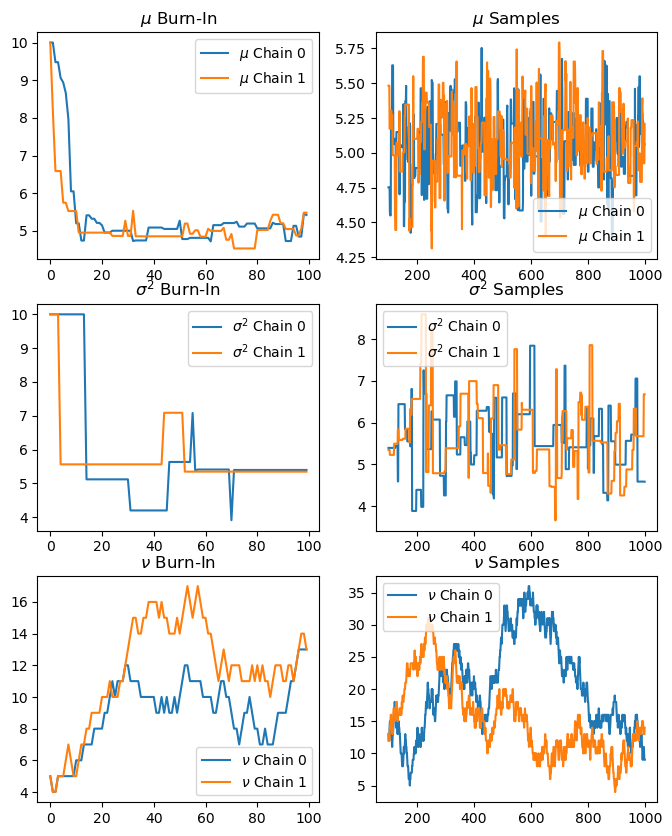

In [13]:
fig,ax = plt.subplots(3, 2, figsize=(8, 10))
ax[0][0].set_title("$\\mu$ Burn-In")
ax[0][1].set_title("$\\mu$ Samples")
ax[1][0].set_title("$\\sigma^2$ Burn-In")
ax[1][1].set_title("$\\sigma^2$ Samples")
ax[2][0].set_title("$\\nu$ Burn-In")
ax[2][1].set_title("$\\nu$ Samples")

burn = 100
demo = 1000
for c in range(C):
    ax[0][0].plot(mu[c,:burn], label="$\\mu$ Chain "+str(c))
    ax[1][0].plot(sigma2[c,:burn], label="$\\sigma^2$ Chain "+str(c))
    ax[2][0].plot(v[c, :burn], label="$\\nu$ Chain "+str(c))
    ax[0][1].plot(np.arange(burn, demo, dtype=int), mu[c,burn:demo], label="$\\mu$ Chain "+str(c))
    ax[1][1].plot(np.arange(burn, demo, dtype=int), sigma2[c,burn:demo], label="$\\sigma^2$ Chain "+str(c))
    ax[2][1].plot(np.arange(burn, demo, dtype=int), v[c,burn:demo], label="$\\nu$ Chain "+str(c))
ax[0][0].legend(); ax[0][1].legend(); 
ax[1][0].legend(); ax[1][1].legend(); 
ax[2][0].legend(); ax[2][1].legend(); 

Acceptance rate = 0.4503
The 95% credible interval of mu is [4.569533686956585, 5.549594910329006]
The 95% credible interval of sigma^2 is [3.946668190817298, 7.497959044204872]
The 95% credible interval of nu is [5.0, 46.0]


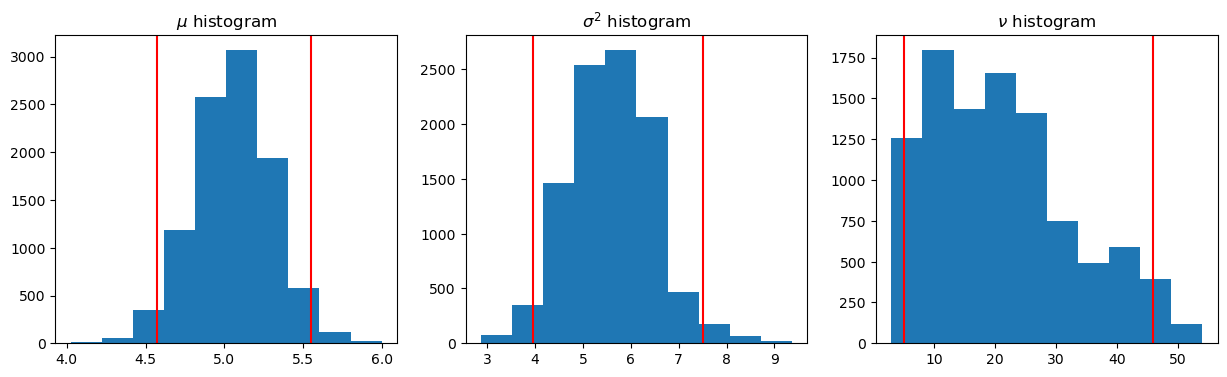

In [14]:
print(f"Acceptance rate = {accept_count/(3*C*G)}")

fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].set_title("$\\mu$ histogram")
ax[1].set_title("$\\sigma^2$ histogram")
ax[2].set_title("$\\nu$ histogram")

ax[0].hist(mu[0, burn:])
lower, upper = np.quantile(mu[0, burn:], (0.025, 0.975))
ax[0].axvline(lower, color="r")
ax[0].axvline(upper, color="r")
print(f"The 95% credible interval of mu is {[lower, upper]}")

ax[1].hist(sigma2[0, burn:])
lower, upper = np.quantile(sigma2[0, burn:], (0.025, 0.975))
ax[1].axvline(lower, color="r")
ax[1].axvline(upper, color="r")
print(f"The 95% credible interval of sigma^2 is {[lower, upper]}")

ax[2].hist(v[0, burn:])
lower, upper = np.quantile(v[0, burn:], (0.025, 0.975))
ax[2].axvline(lower, color="r")
ax[2].axvline(upper, color="r")
print(f"The 95% credible interval of nu is {[lower, upper]}")

### Q2

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [v]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [v]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [v]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


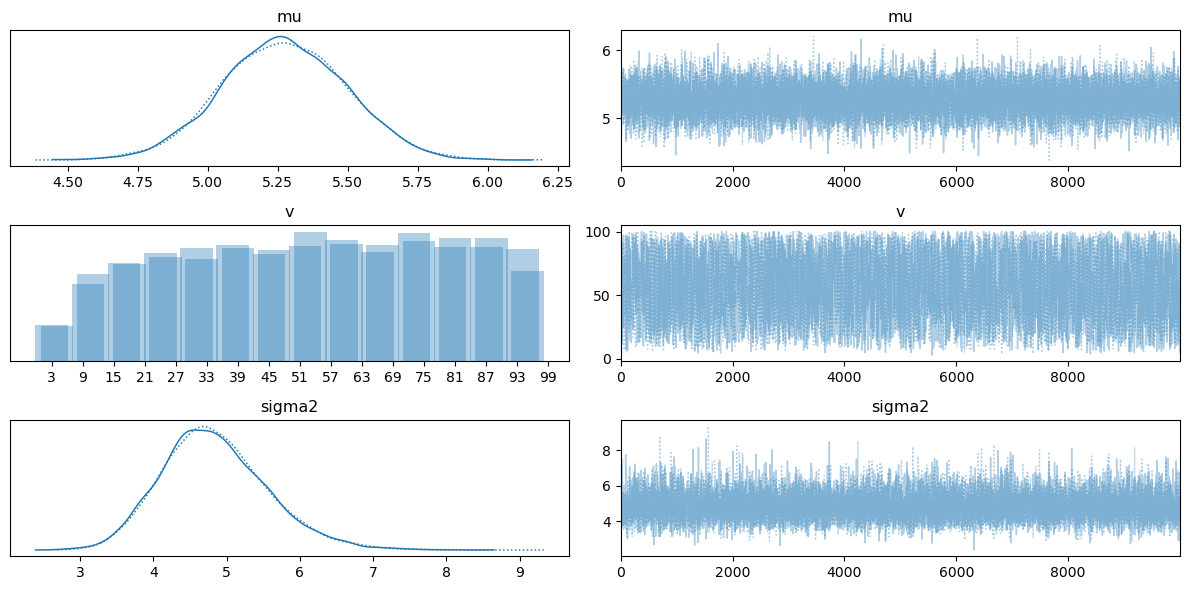

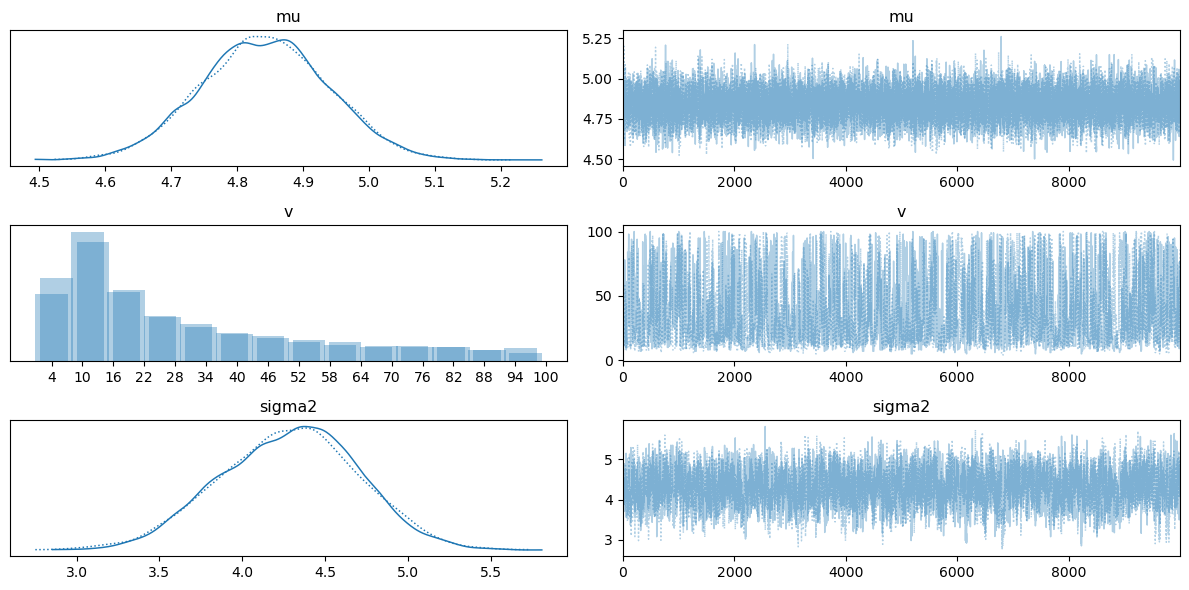

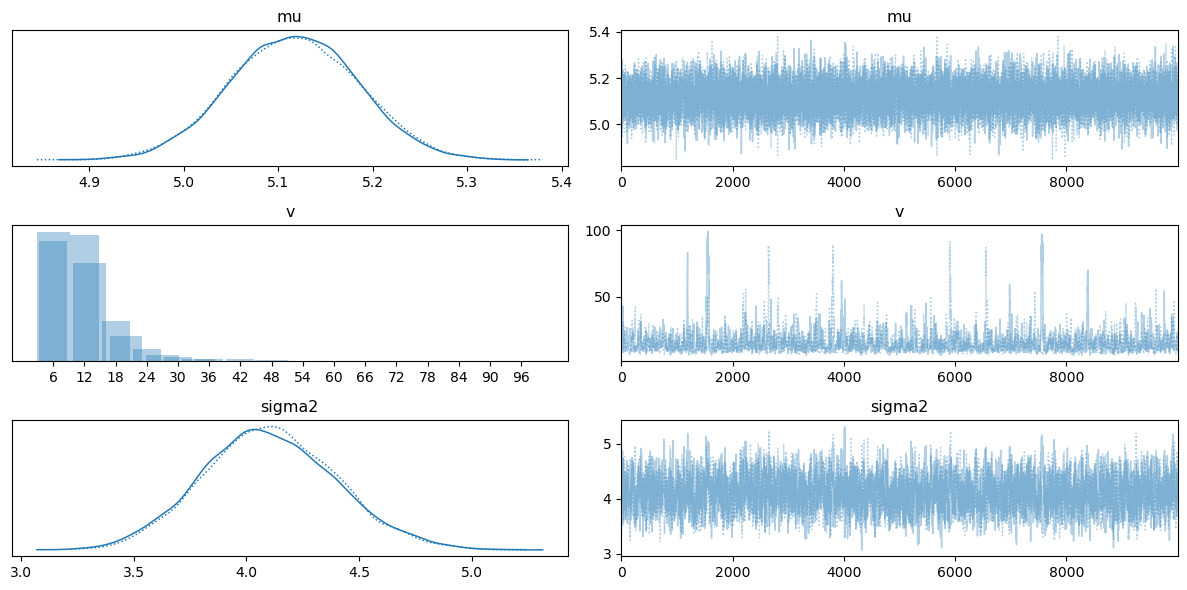

In [ ]:
summary = []
sample_size = [100, 500, 1000]
m = 10000

for n in sample_size:
    x = stats.t(loc=5, scale=2, df=10).rvs(size=n)

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=1, sigma=5)
        sigma2 = pm.HalfNormal("sigma2", sigma=5)
        v = pm.DiscreteUniform("v", lower=1, upper=100)

        x_obs = pm.StudentT("x_obs", mu=mu, sigma=sigma2**0.5, nu=v, observed=x)
        idata = pm.sample(draws=m, chains=2, target_accept=0.8)
    
    az.plot_trace(idata)
    plt.tight_layout()
    summary.append(az.summary(idata, round_to=5))

In [24]:
summary[0]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.27425,0.22379,4.86875,5.70368,0.00158,0.00111,20194.84609,13670.19513,1.00019
v,55.93530,26.17504,14.00000,99.00000,0.42294,0.30287,3829.95268,4014.74518,1.00142
sigma2,4.83358,0.72890,3.46772,6.16433,0.00602,0.00426,14199.01924,10532.59299,1.00012


In [25]:
summary[1]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.84157,0.09670,4.66314,5.02520,0.00079,0.00056,15080.25353,12986.89695,1.00001
v,32.76230,24.74245,5.00000,84.00000,0.69700,0.49297,1010.39026,1306.09788,1.00187
sigma2,4.28449,0.41924,3.47183,5.02596,0.01060,0.00750,1601.25551,3168.54469,1.00174


In [26]:
summary[2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.11680,0.06785,4.98890,5.24275,0.00051,0.00036,17352.03209,13310.22108,1.00031
v,14.61990,8.13745,6.00000,25.00000,0.27746,0.21364,1322.32092,1276.52388,1.00169
sigma2,4.10287,0.29592,3.52579,4.64397,0.00639,0.00454,2159.74154,2996.51283,1.00087


Note that the true value of $\nu$ is 10.
- For $n = 100$, the posterior mean is the highest and furthest from true value $\mathbb{E}(\nu|\mathbf{x},\mu,\sigma^2) = 55$ with sample almost evenly spread across the support of $\nu$ from 1 to 100. This indicates that the model is inaccurate inference on very small sample size. 
- For $n = 500$, the posterior mean is closer to the true value $\mathbb{E}(\nu|\mathbf{x},\mu,\sigma^2) = 32$ with right-skewed sample closer to the true value. The model achieves better accuracy to the real value. 
- For $n = 1000$, the posterior mean is the closest one $\mathbb{E}(\nu|\mathbf{x},\mu,\sigma^2) = 14$ with better and more accurate sample than the lower sample size one. Also, the inference has the narrowest credible interval.

It seems that the higher the sample size, the closer to the true value of $\nu$ we get. However, if we take a look at effective sample size (ESS), the largest sample size has the lowest ESS (around 10-15% of the chain size) while the smallest has the highest ESS.

### Q3

Denote the observed data as $\mathbf{y}$, the posterior predictive distribution is

\begin{align*}
    p(y_i|\mathbf{y})   &= \int_0^\infty p(y_i|\tau_i)p(\tau_i|\mathbf{y})d\tau_i \\
                        &= \int_0^\infty \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {(\frac{\nu}{2})^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i \\
                        &= \frac{(\frac{\nu}{2})^{\frac{\nu}{2}}}{\sqrt{2\pi}\Gamma(\frac{\nu}{2})} \int_0^\infty \tau_i^{\frac{\nu}{2}+\frac{1}{2}-1} e^{-(\frac{\nu}{2}+\frac{1}{2}y_i^2)\tau_i} d\tau_i
\end{align*}

Note that since $\int_0^\infty \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1}e^{-\beta x}dx = 1$, then $\int_0^\infty x^{\alpha-1}e^{-\beta x}dx = \frac{\Gamma(\alpha)}{\beta^\alpha}$.
\begin{align*}
    p(y_i|\mathbf{y})   &= \frac{(\frac{\nu}{2})^{\frac{\nu}{2}}}{\sqrt{2\pi}\Gamma(\frac{\nu}{2})} \cdot \frac{\Gamma(\frac{\nu}{2}+\frac{1}{2})}{(\frac{\nu}{2}+\frac{1}{2}y_i^2)^{\frac{\nu}{2}+\frac{1}{2}}} \\
                        &= \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\pi\nu}\Gamma(\frac{\nu}{2})}\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}} &\text{(Simplify the term)} \\
                        &= t\left(df=\nu\right)
\end{align*}

We can see the behavior above that the likelihood follows normal distribution, but when we integrated out the uncertainty $\tau$ out, we will get t-distribution for posterior predictive distribution. We know that t-distribution is heavy-tailed than the normal distribution, which indicates more uncertainty in the model.

The behavior is analogus to the behavior of the posterior predictive distribution (PPD) in general. The PPD takes the uncertainty of the parameter of the likelihood into account to predict the probability of observing the next value, given the previous observations. Therefore, PPD will have more uncertainty than the one in the likehood. This explains why the derivation above goes from normal distribution (the value close to mean) to t distribution (heavier-tailed) because we don't have the exact value of the parameter, unlike the likelihood, which is conditioned on that parameter.